In [1]:
import torch
import sys
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torchvision import datasets, transforms
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names
from PIL import Image
from tqdm import tqdm
import os
import numpy as np
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import HTML

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/DnnSecurity/Attack/BadNet')
from dataset_clean_cifar import MyDataset
from model import WideResNet

In [4]:
# Prepare Env
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

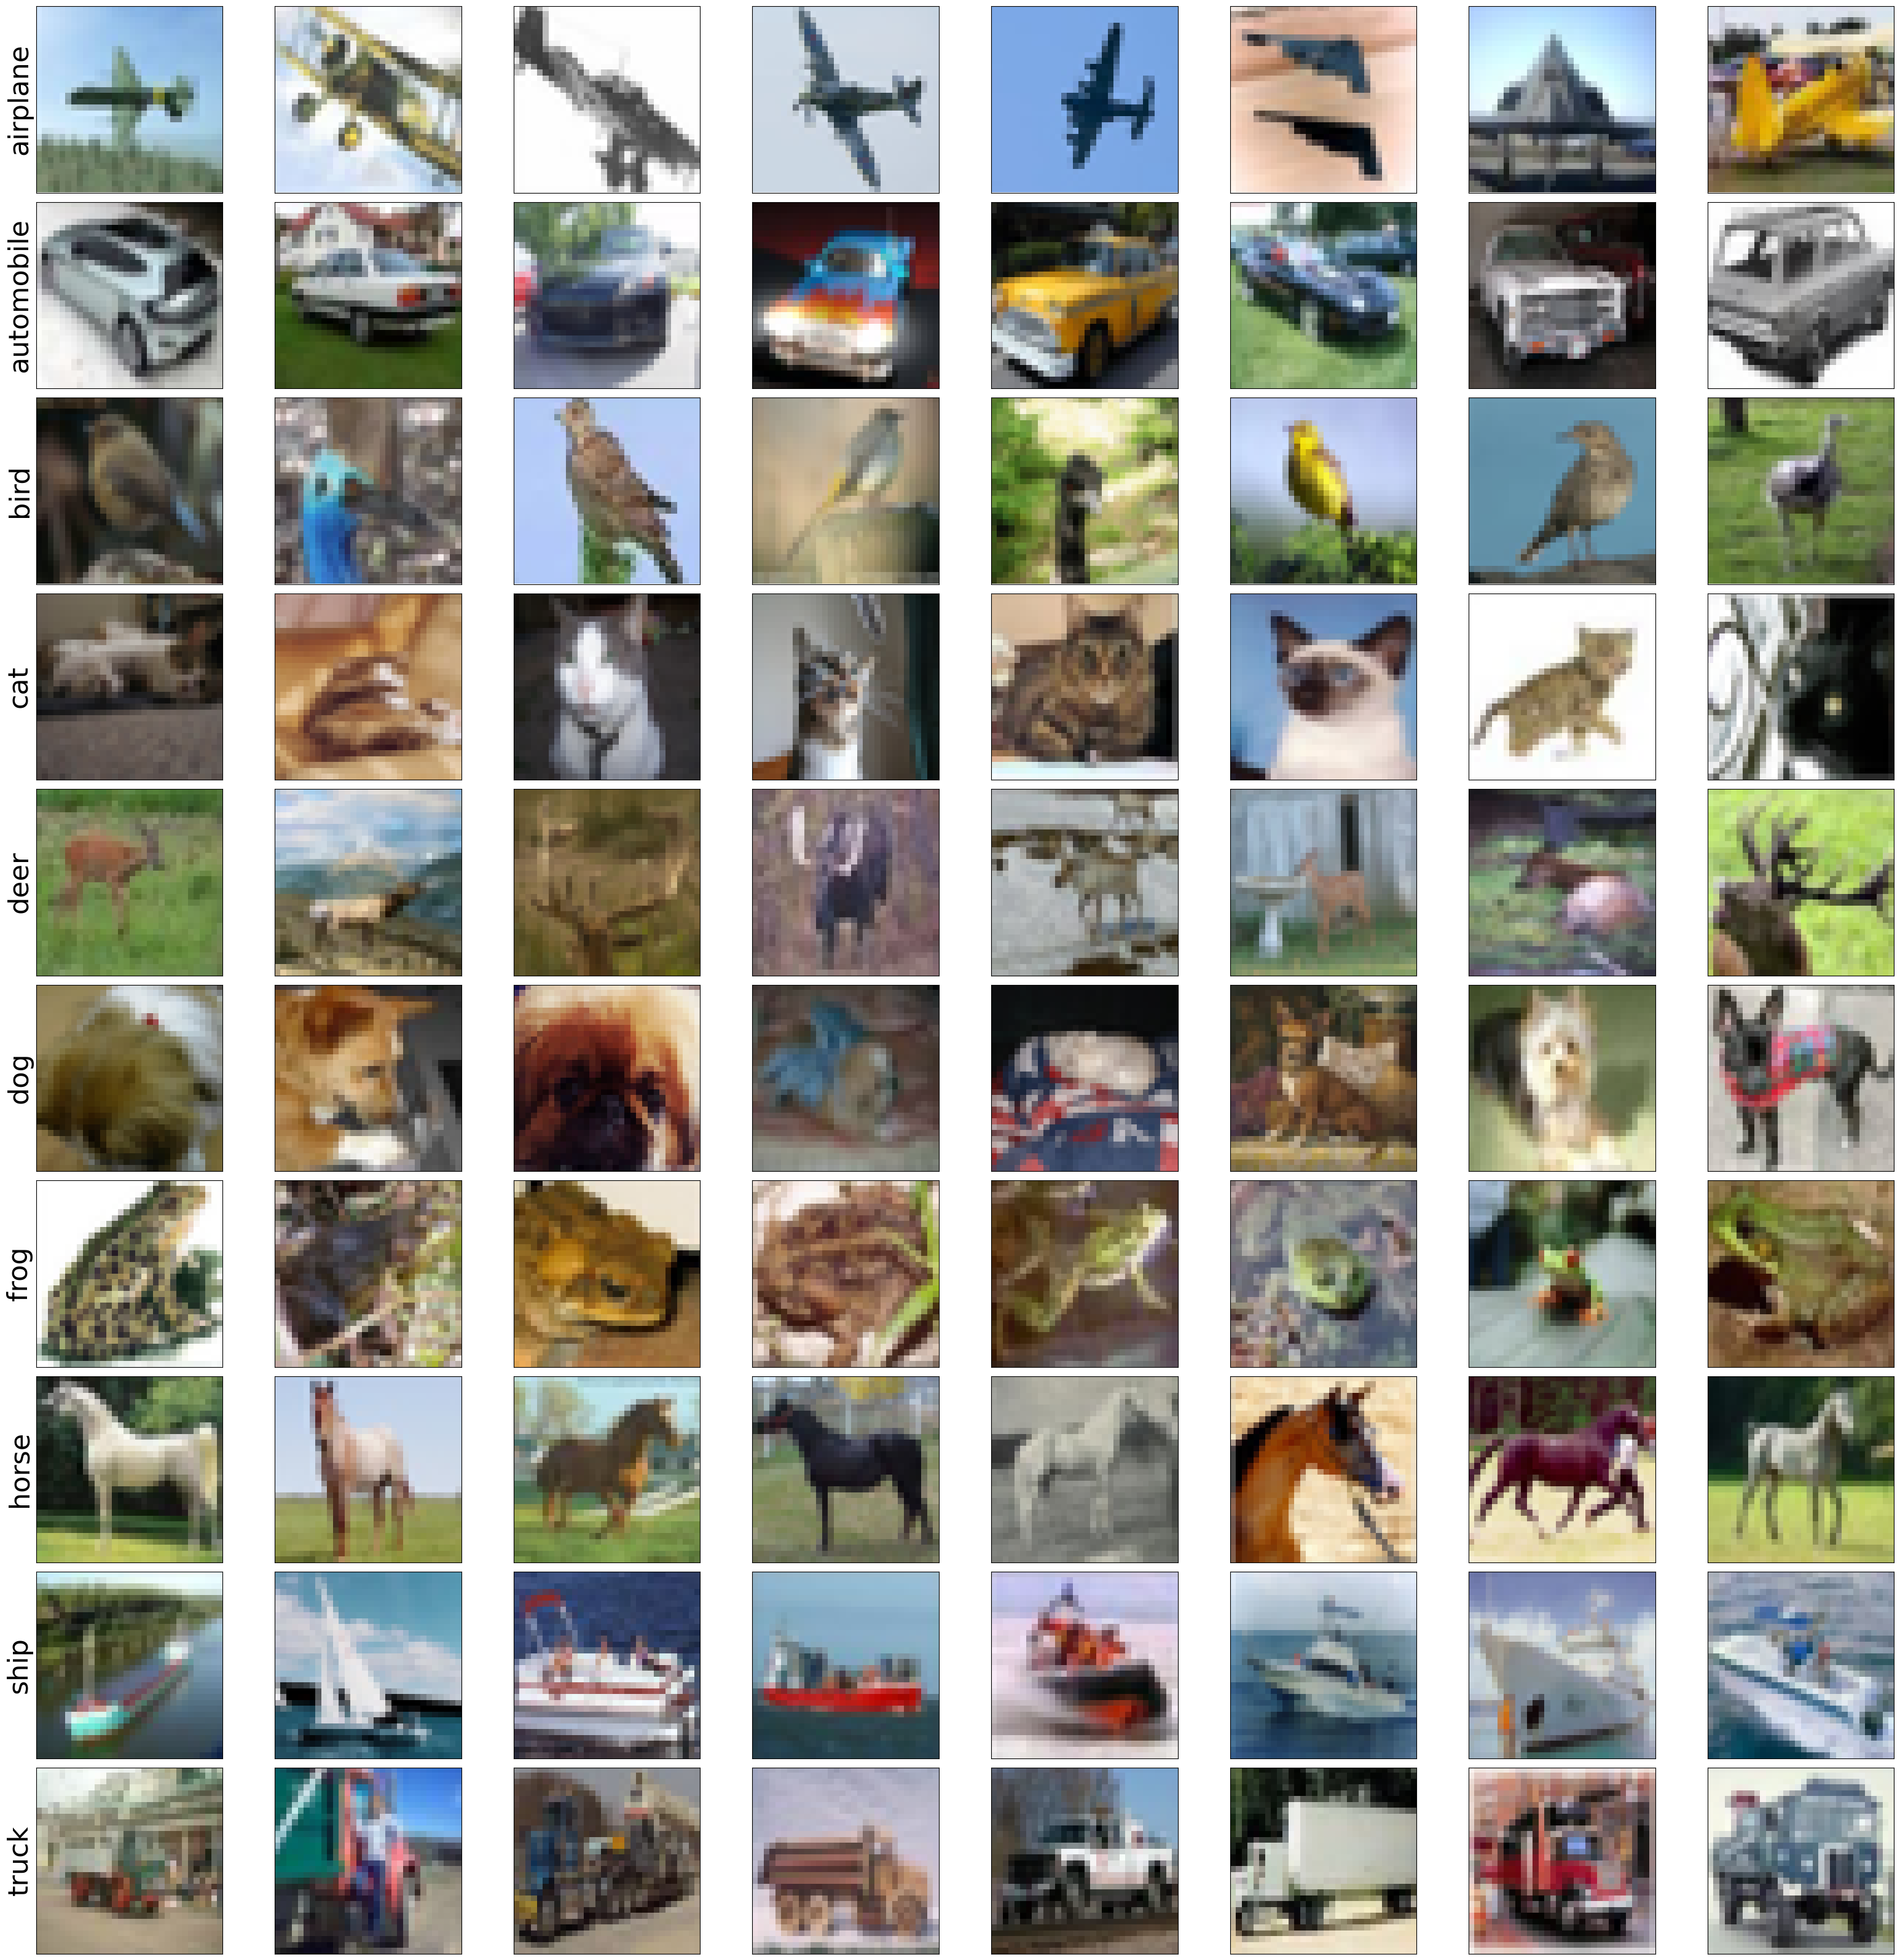

In [5]:
train_folder = '/content/drive/MyDrive/cifar10/32_32/train'
transform = transforms.Compose([transforms.ToTensor()])
train_data_samples = datasets.ImageFolder(train_folder, transform=transform)

class_names = train_data_samples.classes
samples_per_class = 8

plt.figure(figsize=(32,32))

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(train_folder, class_name)
    class_images = os.listdir(class_folder)
    chosen_samples = random.sample(class_images, samples_per_class)

    for i, img_name in enumerate(chosen_samples):
        img_path = os.path.join(class_folder, img_name)
        img = plt.imread(img_path)
        plt.subplot(len(class_names), samples_per_class, class_idx * samples_per_class + i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img)
        if i == 0:
            plt.ylabel(class_name, fontsize=32)

plt.tight_layout()
plt.show()


In [6]:
test_data_folder = datasets.ImageFolder(root="/content/drive/MyDrive/cifar10/32_32/test/")
train_data_folder = datasets.ImageFolder(root="/content/drive/MyDrive/cifar10/32_32/train/")
train_data_folder = test_data_folder

portion = 0
print("Classes:")
for i in range(len(class_names)):
    print(str(i) + ":" + class_names[i])
print("Enter target class index from above classes i.e. 0:")
target = int(input())
print("Generate training data")
print("----------------------------------")
train_data = MyDataset(train_data_folder, target, portion=portion, mode="train", device=device)
print("Generate testing data without backdoor trigger")
print("----------------------------------")
test_data_orig = MyDataset(test_data_folder, target, portion=0, mode="test", device=device)

train_data_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_data_orig_loader = DataLoader(dataset=test_data_orig, batch_size=64, shuffle=True)


Classes:
0:airplane
1:automobile
2:bird
3:cat
4:deer
5:dog
6:frog
7:horse
8:ship
9:truck
Enter target class index from above classes i.e. 0:
Generate training data
----------------------------------
Generate testing data without backdoor trigger
----------------------------------


In [ ]:
def train(net, dl, criterion, opt):
    running_loss = 0
    cnt = 0
    net.train()
    for i, data in tqdm(enumerate(dl)):
        opt.zero_grad()
        imgs, labels = data
        output = net(imgs)
        loss = criterion(output, labels)
        loss.backward()
        opt.step()
        cnt = i
        running_loss += loss.item()  # Use .item() to get the scalar value
    return running_loss / (cnt + 1)  # cnt is index, so add 1 for actual count

def eval(net, dl, batch_size=64):
    cnt = 0
    ret = 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(dl):
            cnt += 1
            imgs, labels = data
            output = net(imgs)
            output = torch.argmax(output, dim=1)
            ret += (output == labels).sum().item()  # Use .item() to get the scalar value
    return ret / (cnt * batch_size)

print("start")
depth = 10
num_classes = 10

# Compile
model = WideResNet(depth, num_classes).to(device)
#if os.path.exists("/content/drive/MyDrive/Colab Notebooks/DnnSecurity/Attack/BadNet/badnet_cifar.pth"):
#    model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/DnnSecurity/Attack/BadNet/badnet_cifar.pth", map_location=device))
criterion = nn.CrossEntropyLoss()
sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
summary(model, (3, 32, 32))

print("Enter number of epoch i.e. 100:")
epoch = int(input())
for e in range(epoch):
    train_loss = train(model, train_data_loader, criterion, sgd)
    accuracy = eval(model, test_data_orig_loader)
    print(f"Epoch {e+1}, Loss: {train_loss}, Accuracy: {accuracy}")


start
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
        BasicBlock-8           [-1, 16, 32, 32]               0
      NetworkBlock-9           [-1, 16, 32, 32]               0
      BatchNorm2d-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 32, 16, 16]           4,608
      BatchNorm2d-13           [-1, 32, 16, 16]              64
             ReLU-14           [-

157it [00:02, 61.00it/s]


Epoch 1, Loss: 2.2664281304474847, Accuracy: 0.20790207006369427


157it [00:01, 87.66it/s]


Epoch 2, Loss: 2.1600487718156947, Accuracy: 0.25039808917197454


157it [00:01, 87.52it/s]


Epoch 3, Loss: 2.076009467908531, Accuracy: 0.26343550955414013


157it [00:02, 73.71it/s]


Epoch 4, Loss: 2.008358744299336, Accuracy: 0.28115047770700635


157it [00:01, 84.87it/s]


Epoch 5, Loss: 1.9533962884526344, Accuracy: 0.2900079617834395


157it [00:01, 86.48it/s]


Epoch 6, Loss: 1.9040070855693452, Accuracy: 0.2961783439490446


157it [00:01, 87.68it/s]


Epoch 7, Loss: 1.865693796971801, Accuracy: 0.3078224522292994


157it [00:01, 83.45it/s]


Epoch 8, Loss: 1.831124932143339, Accuracy: 0.34623805732484075


157it [00:02, 68.97it/s]


Epoch 9, Loss: 1.800716210322775, Accuracy: 0.3580812101910828


157it [00:01, 85.72it/s]


Epoch 10, Loss: 1.7724872098606863, Accuracy: 0.3635549363057325


In [ ]:
print("start training: ")
for i in range(epoch):
    loss_train = train(model, train_data_loader, criterion, sgd)
    acc_train = eval(model, train_data_loader)
    acc_test_orig = eval(model, test_data_orig_loader, batch_size=64)
    #acc_test_trig = eval(model, test_data_trig_loader, batch_size=64)
    #print(f"epoch{i + 1}   loss: {loss_train:.5f}  training accuracy: {acc_train:.5f}  testing Orig accuracy: {acc_test_orig:.5f}  testing Trig accuracy: {acc_test_trig:.5f}")
    print(f"epoch{i + 1}   loss: {loss_train:.5f}  testing Orig accuracy: {acc_test_orig:.5f}")
    torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/DnnSecurity/Attack/BadNet/badnet_cifar.pth")
print("finish training")

start training: 


157it [00:02, 66.11it/s]


epoch1   loss: 1.73037  testing Trig accuracy: 0.37162


157it [00:01, 82.39it/s]


epoch2   loss: 1.70794  testing Trig accuracy: 0.37082


157it [00:01, 84.05it/s]


epoch3   loss: 1.68553  testing Trig accuracy: 0.38177


157it [00:01, 84.37it/s]


epoch4   loss: 1.66081  testing Trig accuracy: 0.39421


157it [00:01, 81.63it/s]


epoch5   loss: 1.63907  testing Trig accuracy: 0.38903


157it [00:01, 85.24it/s]


epoch6   loss: 1.61660  testing Trig accuracy: 0.40466


157it [00:01, 84.31it/s]


epoch7   loss: 1.59875  testing Trig accuracy: 0.40297


157it [00:02, 65.62it/s]


epoch8   loss: 1.57576  testing Trig accuracy: 0.40963


157it [00:01, 85.14it/s]


epoch9   loss: 1.55879  testing Trig accuracy: 0.42854


157it [00:01, 83.19it/s]


epoch10   loss: 1.53545  testing Trig accuracy: 0.42735
finish training


In [ ]:
# Choose the class index
print("Class index (0-9):")
class_idx = int(input())

# Get the image paths for the selected class
class_images = [img for img in train_data_samples.imgs if img[1] == class_idx]

# Choose wanted image index within the selected class
print(f"Image index (0-{len(class_images)-1}):")
img_idx = int(input())

# Get the image path from the dataset
img_path, _ = class_images[img_idx]

# Load and preprocess the image
img = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to the input size expected by the model
    transforms.ToTensor(),        # Convert image to tensor
])
image = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Display the chosen image
plt.imshow(img)
plt.title(f"Chosen Image Index: {img_idx} from Class: {class_idx}")
plt.axis('off')
plt.show()

# List available layers in the model
train_nodes, eval_nodes = get_graph_node_names(model)
print("Available layers in the model:")
for node in eval_nodes:
    print(node)

# Input the wanted layer
print("Enter the target layer (copy from above list):")
target_layer = input()

# Validate the target layer
if target_layer not in eval_nodes:
    raise ValueError(f"Layer {target_layer} Invalid layer.")

# Define the layers to extract features
return_nodes = {
    target_layer: "target_layer_output"
}

# Create the feature extractor
model.eval()
model2 = create_feature_extractor(model, return_nodes=return_nodes)

# Get the intermediate outputs
with torch.no_grad():
    intermediate_outputs = model2(image)

# Access the output from the specified layer
target_layer_output = intermediate_outputs["target_layer_output"]
target_layer_output_np = target_layer_output.detach().cpu().numpy() # Can't be performed on CUDA

print(f"Output shape from {target_layer}: {target_layer_output_np.shape}")

Image index:
5
Available layers in the model:
x
conv1
block1.layer.0.bn1
block1.layer.0.relu1
block1.layer.0.conv1
block1.layer.0.bn2
block1.layer.0.relu2
block1.layer.0.conv2
block1.layer.0.add
block2.layer.0.bn1
block2.layer.0.relu1
block2.layer.0.conv1
block2.layer.0.bn2
block2.layer.0.relu2
block2.layer.0.conv2
block2.layer.0.convShortcut
block2.layer.0.add
block3.layer.0.bn1
block3.layer.0.relu1
block3.layer.0.conv1
block3.layer.0.bn2
block3.layer.0.relu2
block3.layer.0.conv2
block3.layer.0.convShortcut
block3.layer.0.add
bn1
relu
avg_pool2d
size
view
fc
Enter the target layer (copy from above list):
block3.layer.0.bn1
Output shape from block3.layer.0.bn1: (1, 32, 16, 16)


In [ ]:
'''
You have to change the parameters in the class Autoencoder to fit your needs. Get your parameters from the output of the previous cell.
'''
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(512, 256, 1),
            nn.ReLU(),
            nn.Conv2d(256, 128, 1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 256, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize and apply the autoencoder
autoencoder = Autoencoder().to(device)
autoencoder.eval()

# Apply the autoencoder to the target layer output
with torch.no_grad():
    encodered_output = autoencoder(target_layer_output)

print(f"Encodered output shape: {encodered_output.shape}")